In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import mpl_toolkits.mplot3d.art3d as art3d
import py_gauge_mc

In [2]:
def p_to_dim_dim(p):
    if p == 3:
        return 1,2,3
    if p == 4:
        return 1,3,2
    if p == 5:
        return 2,3,1
    return None


def plot_state(state):
    T = np.arange(state.shape[0])
    X = np.arange(state.shape[1])
    Y = np.arange(state.shape[2])
    Z = np.arange(state.shape[3])
    P = np.arange(state.shape[4])
    TT, XX, YY, ZZ, PP = np.meshgrid(T,X,Y,Z,P)
    indices = np.stack([TT,XX,YY,ZZ,PP], axis=-1)
    nonzero_indices = indices[state!=0,:]
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim((0,state.shape[1]))
    ax.set_ylim((0,state.shape[2]))
    ax.set_zlim((0,state.shape[3]))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    dims = ['x', 'y', 'z']
    for (t,x,y,z,p) in indices.reshape(-1,5):
        if t != 0:
            continue
        index = [x,y,z]
        
        pdims = p_to_dim_dim(p)
        
        if pdims is not None:
            first,second,normal = pdims
            
            zdir = dims[normal - 1]
            if zdir == "y":
                xy1, z1 = (x, z), y
            elif zdir == "x":
                xy1, z1 = (y, z), x
            else:
                xy1, z1 = (x, y), z
            
            p = Rectangle(xy1, 1, 1, color='blue', alpha=0.1 * abs(state[t,x,y,z,p]))
            ax.add_patch(p)
            art3d.pathpatch_2d_to_3d(p, z=z1, zdir=zdir)

In [3]:
graph = py_gauge_mc.GPUGaugeTheory(8,8,8,8,[(n**2)/2.0 for n in range(30)])

# for x in range(2,6):
#     for y in range(2,6):
#         graph.add_flux(0,x,y,3,3,amount=5)
        
for i in range(128):
    plot_state(graph.get_graph_state())
    plt.savefig('images/{}.png'.format(str(i).zfill(2)), dpi=300)
    plt.close()
    graph.run_local_update()

plot_state(graph.get_graph_state())
plt.savefig('images/{}.png'.format(str(i+1).zfill(2)), dpi=300)
plt.close()

## Time for 10 update sweeps on 24 core CPU versus GTX 3070

In [4]:
graph = py_gauge_mc.GaugeTheory(16,16,16,16,[(n**2)/2.0 for n in range(30)])

def run():
    graph.run_local_update(10)
    graph.get_graph_state()

%timeit run()

9.71 s ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
graph = py_gauge_mc.GPUGaugeTheory(16,16,16,16,[(n**2)/2.0 for n in range(30)])

def run():
    graph.run_local_update(10)
    graph.get_graph_state()

%timeit run()

3.25 ms ± 70.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Global Updates

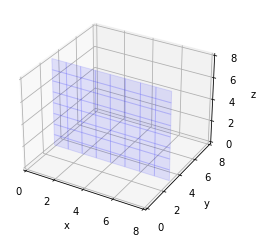

In [6]:
graph = py_gauge_mc.GaugeTheory(8,8,8,8,[(n**2)/2.0 for n in range(30)])

graph.apply_global_updates([0]*67 + [1])

plot_state(graph.get_graph_state())

In [7]:
graph = py_gauge_mc.GaugeTheory(8,8,8,8,[(n**2)/2.0 for n in range(30)])
print(graph.get_global_plane_energy_cost(67))
graph.apply_global_updates([0]*67 + [1])
print(graph.get_global_plane_energy_cost(67))
graph.apply_global_updates([0]*67 + [-1])
print(graph.get_global_plane_energy_cost(67))

(32.0, 32.0)
(-32.0, 96.0)
(32.0, 32.0)


In [8]:
graph = py_gauge_mc.GaugeTheory(4,4,4,4,[(n**2)/2.0 for n in range(20)])
num_planes = graph.get_num_global_planes()

choices = [0]*num_planes

for i in range(num_planes):
    choices[i] = 1
    graph.apply_global_updates(choices)
    state = graph.get_graph_state()
    choices[i] = -1
    graph.apply_global_updates(choices)
    choices[i] = 0
    
    plaquette_sum = state.sum(axis=tuple(range(state.ndim - 1)))
    assert sorted(plaquette_sum) == [0,0,0,0,0,16]

## GPU Global

[0 0 0 0 0 0]


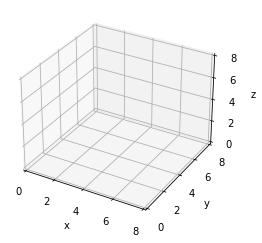

In [9]:
graph = py_gauge_mc.GPUGaugeTheory(8,8,8,8,[(n**2)/5.0 for n in range(30)])
graph.run_global_update()

plot_state(graph.get_graph_state())
print(graph.get_winding_nums())

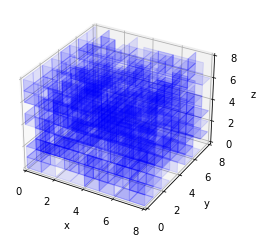

In [10]:
graph.run_local_update()

plot_state(graph.get_graph_state())

[ 0  0  0  1 -1  0]


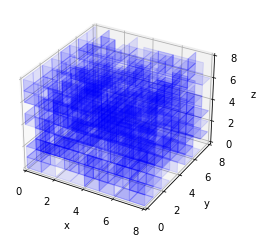

In [11]:
graph.run_global_update()

plot_state(graph.get_graph_state())
print(graph.get_winding_nums())

## GPU Timings

In [12]:
graph = py_gauge_mc.GPUGaugeTheory(8,8,8,8,[(n**2)/2.0 for n in range(30)])

def run():
    graph.simulate_and_get_winding_variance(100,10)

%timeit run()

314 ms ± 3.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
graph = py_gauge_mc.GPUGaugeTheory(16,16,16,16,[(n**2)/2.0 for n in range(30)])

def run():
    graph.simulate_and_get_winding_variance(100,10)

%timeit run()

359 ms ± 6.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
